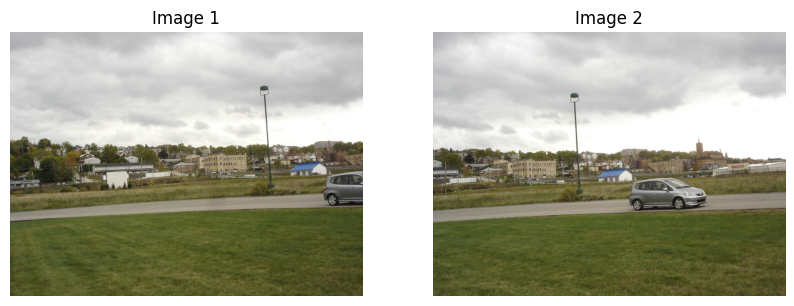

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
img1 = cv2.imread('Q2/Working set/I1.jpg')
img2 = cv2.imread('Q2/Working set/I2.jpg')

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Image 1')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Image 2')
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()


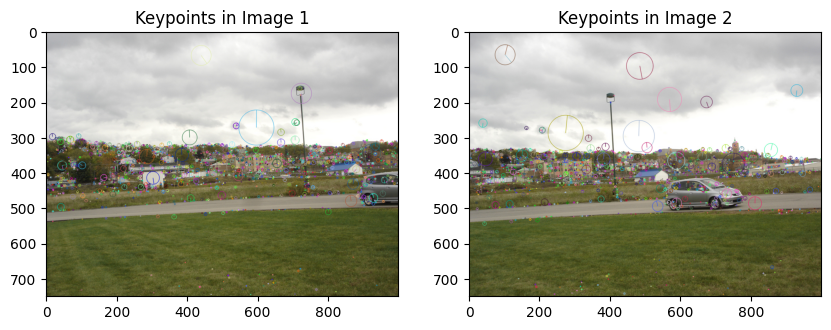

In [41]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect SIFT features and compute descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Draw keypoints on the images
img1_kp = cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv2.drawKeypoints(img2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display keypoints
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Keypoints in Image 1')
plt.imshow(cv2.cvtColor(img1_kp, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Keypoints in Image 2')
plt.imshow(cv2.cvtColor(img2_kp, cv2.COLOR_BGR2RGB))
plt.show()


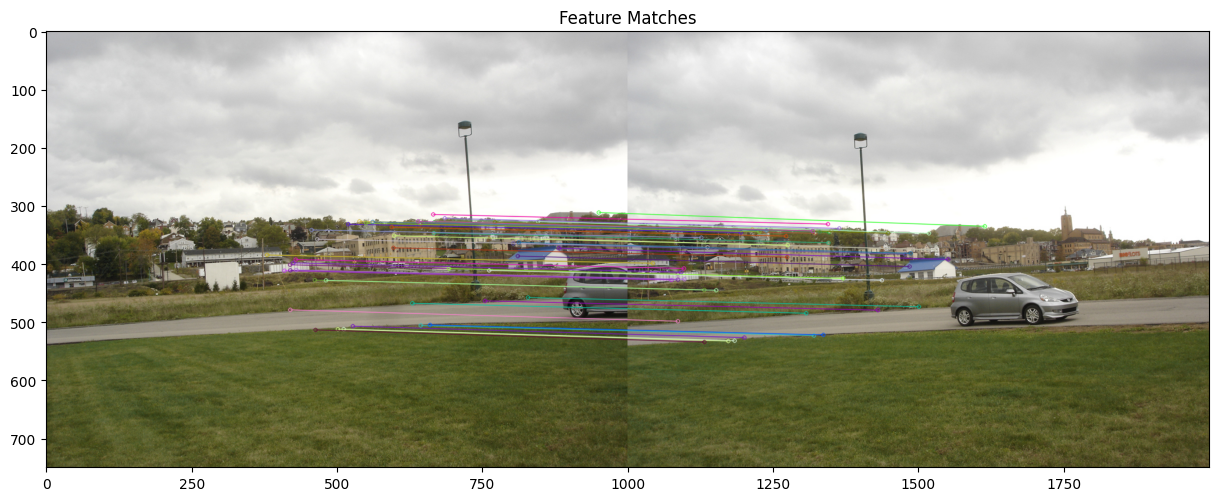

In [42]:
# Initialize the BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw the first 50 matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display matches
plt.figure(figsize=(15, 10))
plt.title('Feature Matches')
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.show()


In [43]:
# Extract location of good matches
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Find the Homography matrix
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Number of inliers
inliers = mask.ravel().sum()
print(f'Number of inliers: {inliers}')

# Display the homography matrix
print('Homography Matrix:')
print(H)


Number of inliers: 589
Homography Matrix:
[[ 1.19938359e+00 -1.56918083e-02 -4.03495283e+02]
 [ 9.19158979e-02  1.12816143e+00 -4.05016921e+01]
 [ 2.04800112e-04 -1.07884747e-05  1.00000000e+00]]


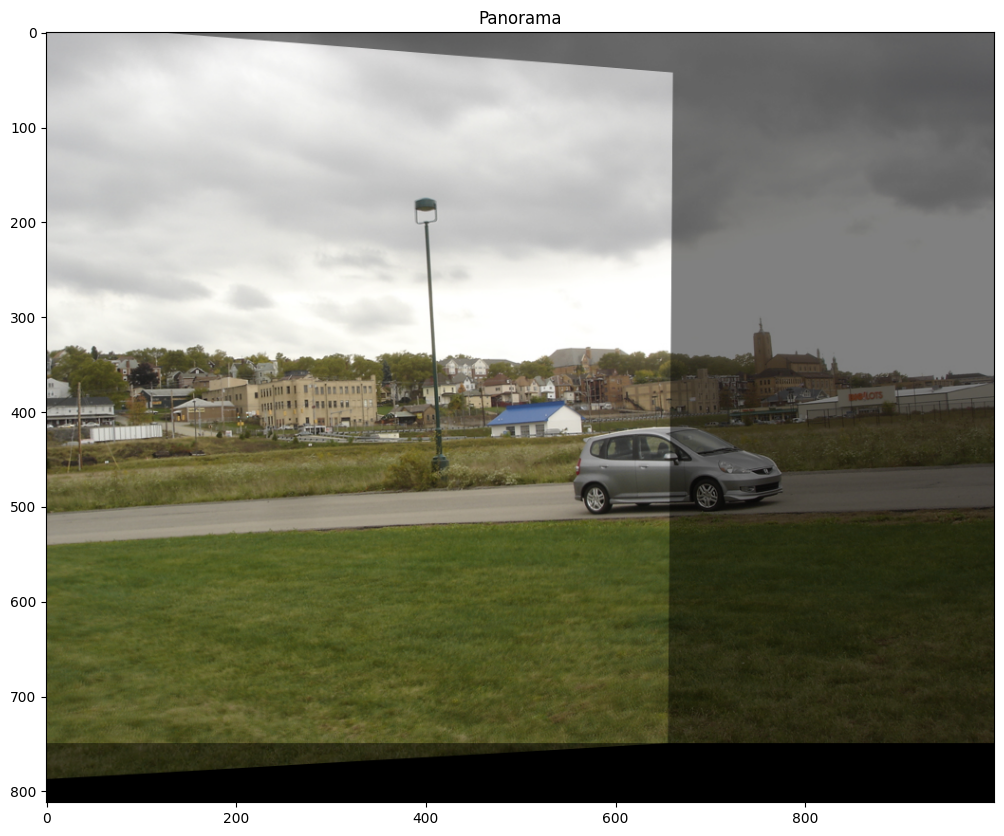

In [44]:
# Get the dimensions of the images
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]

# Corners of the first image
corners_img1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)

# Warp the corners of the first image
corners_img1_warped = cv2.perspectiveTransform(corners_img1, H)

# Create a canvas to fit both images
canvas_width = max(corners_img1_warped[:, 0, 0].max(), w2)
canvas_height = max(corners_img1_warped[:, 0, 1].max(), h2)
canvas = np.zeros((int(canvas_height), int(canvas_width), 3), dtype=np.uint8)

# Warp the first image
warp_img1 = cv2.warpPerspective(img1, H, (canvas.shape[1], canvas.shape[0]))

# Place the second image on the canvas
canvas[:h2, :w2] = img2

# Overlay the warped first image
canvas = cv2.addWeighted(canvas, 0.5, warp_img1, 0.5, 0)

# Display the panorama
plt.figure(figsize=(15, 10))
plt.title('Panorama')
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.show()


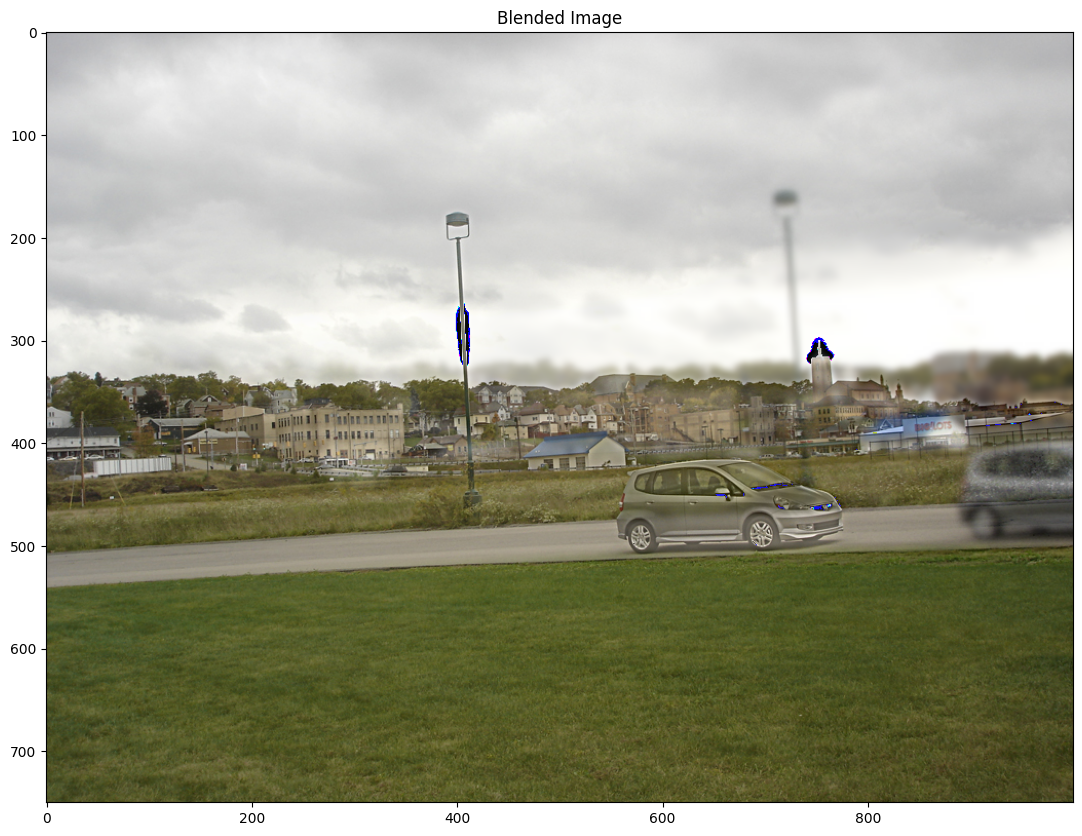

In [45]:
# Create a mask for blending
mask1 = np.zeros_like(img1, dtype=np.float32)
mask2 = np.zeros_like(img2, dtype=np.float32)
rows, cols, _ = img1.shape

# Gradient mask
for i in range(cols):
    mask1[:, i] = i / cols
    mask2[:, i] = 1 - mask1[:, i]

# Convert masks to grayscale
mask1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)
mask2 = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY)

# Expand mask dimensions to match image dimensions
mask1 = np.dstack([mask1] * 3)
mask2 = np.dstack([mask2] * 3)

# Create Gaussian pyramids
gpA = [img1.astype(np.float32)]
gpB = [img2.astype(np.float32)]
gpMask1 = [mask1.astype(np.float32)]
gpMask2 = [mask2.astype(np.float32)]

for i in range(2):  # Use 2 levels
    img1 = cv2.pyrDown(img1)
    img2 = cv2.pyrDown(img2)
    mask1 = cv2.pyrDown(mask1)
    mask2 = cv2.pyrDown(mask2)
    gpA.append(img1.astype(np.float32))
    gpB.append(img2.astype(np.float32))
    gpMask1.append(mask1.astype(np.float32))
    gpMask2.append(mask2.astype(np.float32))

# Create Laplacian pyramids
lpA = [gpA[-1]]
lpB = [gpB[-1]]
lpMask1 = [gpMask1[-1]]
lpMask2 = [gpMask2[-1]]

for i in range(2, 0, -1):
    size = (gpA[i-1].shape[1], gpA[i-1].shape[0])
    lapA = cv2.subtract(gpA[i-1], cv2.pyrUp(gpA[i], dstsize=size))
    lapB = cv2.subtract(gpB[i-1], cv2.pyrUp(gpB[i], dstsize=size))
    lapMask1 = cv2.subtract(gpMask1[i-1], cv2.pyrUp(gpMask1[i], dstsize=size))
    lapMask2 = cv2.subtract(gpMask2[i-1], cv2.pyrUp(gpMask2[i], dstsize=size))
    lpA.append(lapA)
    lpB.append(lapB)
    lpMask1.append(lapMask1)
    lpMask2.append(lapMask2)

# Blend the images using the masks
LS = []
for la, lb, lm1, lm2 in zip(lpA, lpB, lpMask1, lpMask2):
    blend = la * lm1 + lb * (1 - lm1)
    LS.append(blend)

# Reconstruct the image from the pyramid
ls_ = LS[0]
for i in range(1, 3):
    ls_ = cv2.pyrUp(ls_, dstsize=(LS[i].shape[1], LS[i].shape[0]))
    ls_ = cv2.add(ls_, LS[i])

# Display the blended image
plt.figure(figsize=(15, 10))
plt.title('Blended Image')
plt.imshow(cv2.cvtColor(ls_.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()


In [51]:
# Load the third image
img3 = cv2.imread('Q2/Working set/I3.jpg')

# Ensure all images are the same size
img3 = cv2.resize(img3, (img2.shape[1], img2.shape[0]))

# Detect features and match with the second image
kp3, des3 = sift.detectAndCompute(img3, None)
matches_23 = bf.match(des2, des3)
matches_23 = sorted(matches_23, key=lambda x: x.distance)

# Extract location of good matches
src_pts_23 = np.float32([kp2[m.queryIdx].pt for m in matches_23]).reshape(-1, 1, 2)
dst_pts_23 = np.float32([kp3[m.trainIdx].pt for m in matches_23]).reshape(-1, 1, 2)

# Find the Homography matrix between img2 and img3
H_23, mask_23 = cv2.findHomography(src_pts_23, dst_pts_23, cv2.RANSAC, 5.0)

# Warp img3 to the plane of img2
warp_img3 = cv2.warpPerspective(img3, H_23, (canvas.shape[1], canvas.shape[0]))

# Create a new canvas to hold the three images
canvas = np.zeros((int(canvas_height), int(canvas_width), 3), dtype=np.uint8)

# Place the first two images
canvas[:h2, :w2] = img2
canvas = cv2.addWeighted(canvas, 0.5, warp_img1, 0.5, 0)

# Overlay the third image
canvas = cv2.addWeighted(canvas, 0.5, warp_img3, 0.5, 0)

# Display the panorama with three images
plt.figure(figsize=(15, 10))
plt.title('Panorama with Three Images')
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.show()


ValueError: could not broadcast input array from shape (188,250,3) into shape (750,1000,3)